# Data Analysis
Purpose is to ping MAL's APIs to gather anime data. The data will then be saved into a `.csv` to be used for the DSC106 - Final Project Website.<br>
By: Jonathan Lo<br>
Date: 5/2/23

## Imports and Setup

In [1]:
# Imports
import json
import pandas as pd
import requests as r

from time import sleep
from tqdm import tqdm
from datetime import timedelta

In [2]:
# Unload Secrets
with open("secrets.json", 'r') as fh:
    secrets = json.load(fh)
    
mal_client_id = secrets['MAL-CID']

## Requests

In [3]:
endpoint = "https://api.myanimelist.net/v2/anime/"
headers = {"X-MAL-CLIENT-ID": mal_client_id}
fields = [
    "start_date",
    "end_date",
    "mean",
    "rank",
    "popularity",
    "num_list_users",
    "num_scoring_users",
    "media_type",
    "status",
    "genres",
    "start_season",
    "source",
    "rating",
    "recommendations",
    "studios"
]
payload = {"fields": str(fields).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')}

def queryMALRange(top_range, timeout=0.75):
    """ Queries MyAnimeList's database for a certain range.
    """
    # Metadata
    print(f"The expected time to pull all data is: {timedelta(seconds=top_range * 0.875)}")
    
    # Init
    error_timeout = 20
    myanmielistData = []
    requery_ids = []
    session = r.Session()
    
    # First Loop
    for i in tqdm(range(1, top_range)):
        res = r.get(
            endpoint + str(i),
            params=payload,
            headers=headers
        )
        if res.status_code == 200:
            myanmielistData.append(res.json())
        elif res.status_code == 404:
            continue
        else:
            requery_ids.append(i)
            sleep(error_timeout)
        sleep(timeout)
        
    # Requery if any traffic errors
    for i in tqdm(requery_ids):
        res = r.get(
            endpoint + str(i),
            params=payload,
            headers=headers
        )
        if res.status_code == 200:
            myanmielistData.append(res.json())
        sleep(timeout)
        
    return myanmielistData

In [4]:
# Mass request
data = queryMALRange(50000)

The expected time to pull all data is: 12:09:10


100%|████████████████████████████████████████████████████████████████████████████████| 768/768 [11:56<00:00,  1.07it/s]


In [5]:
# Saving data
with open("myanimelist-data.json", "w") as fh:
    json.dump(data, fh)

## Analysis

In [3]:
# Load data into a DataFrame
try:
    df = pd.DataFrame(data)
except NameError as e:
    with open("myanimelist-data.json", "r") as fh:
        malData = json.load(fh)
    df = pd.DataFrame(malData)

In [68]:
# Getting the counts of anime over the years
df['year'] = df['start_date'].astype(str).apply(lambda x: x[:4]).astype(int, errors='ignore')
year_counts = df.groupby("year")['id'].count()
year_counts

year
1917     16
1918      9
1924      5
1925      9
1926      6
       ... 
2021    676
2022    187
2023     52
2024      3
nan     737
Name: id, Length: 104, dtype: int64

<Axes: title={'center': 'Count of Anime vs. Time'}, xlabel='year'>

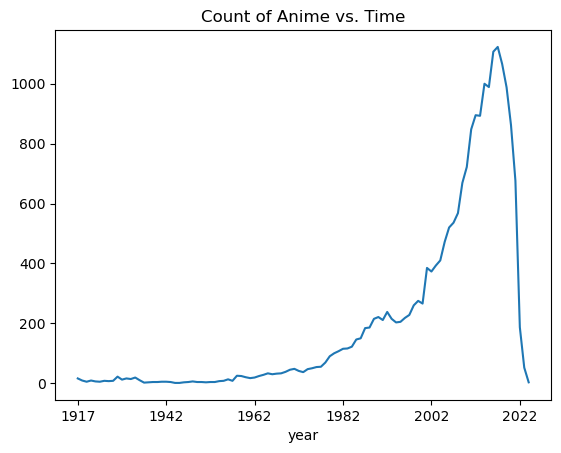

In [69]:
# Ploting such data
year_counts.drop("nan").plot(title="Count of Anime vs. Time")

Although not a super great indicator, we can track how many people watch anime over the years by using the most popular show for each year. This should show any outlier spikes

<Axes: xlabel='year'>

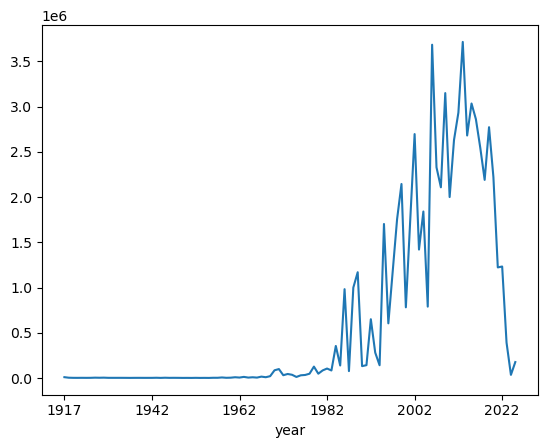

In [73]:
# Number of members
most_members_year = df.groupby("year")['num_list_users'].max()

Interested in investigating the quality (or the perception of) anime over the years. We can investigate this by averaging the scores of each anime per year.

<Axes: title={'center': '2000s-Present Average Anime Score per Year'}, xlabel='year'>

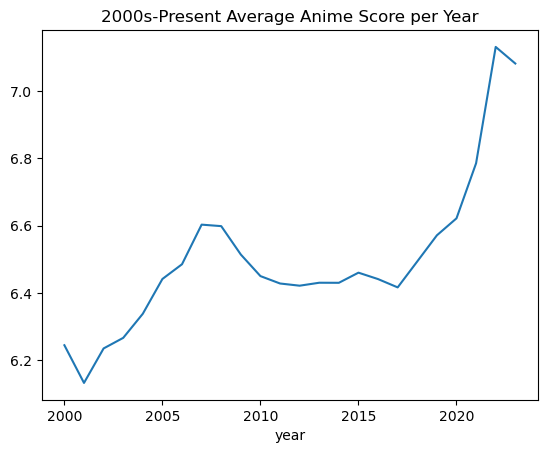

In [222]:
# Finding for each year for most recent years
avg_score_year = df.groupby('year')['mean'].mean().drop("nan")
avg_score_year["2000":].plot(title="2000s-Present Average Anime Score per Year")

In [127]:
def flatten_tags(target):
    """ Givem a target to flatten, returns a list of only that tag.
    """
    if not isinstance(target, list):
        return pd.NA
    flattened = []
    for o in target:
        flattened.append(o["name"])
    return flattened

In [137]:
# Generate Counts for Each Genre by Year
genre_count = {}
for index, row in df.iterrows():
    year = row['year']
    genres = row['genres']
    if not isinstance(genres, list):
        continue
    for genre in genres:
        if genre not in genre_count:
            genre_count[genre] = {}
        if year not in genre_count[genre]:
            genre_count[genre][year] = 0
        genre_count[genre][year] += 1

In [152]:
# Get the 10 most popular over the years
top_genre_df = pd.DataFrame(genre_count)
top_popular = top_genre_df.sum().sort_values(ascending=False)[:10]

<Axes: title={'center': 'Count of Top Genres vs. Time'}, xlabel='index'>

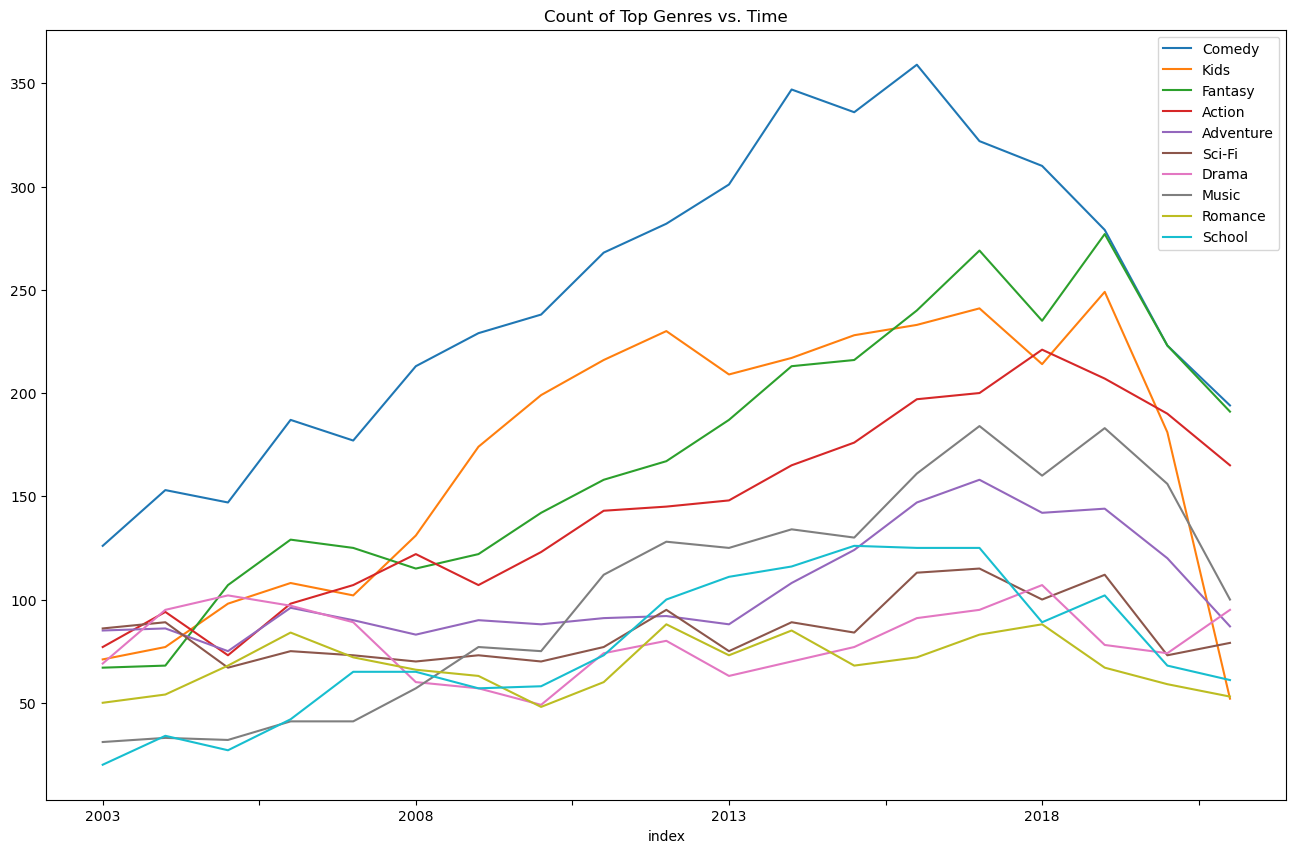

In [220]:
# Looing at the top 10 most popular in recent years
temp = top_genre_df[top_popular.keys()].reset_index().sort_values(by="index", ascending=False)
temp.iloc[4:23].sort_values(by="index").set_index("index").plot(figsize=(16,10), title="Count of Top Genres vs. Time")

<Axes: title={'center': 'Counts of Media Types'}>

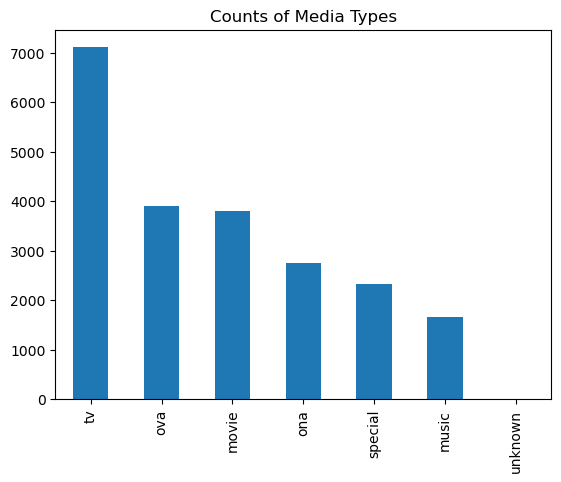

In [230]:
# Counts of Media Types
df['media_type'].value_counts().plot.bar(title="Counts of Media Types")

In [4]:
# Finding total number of nodes and edges
print("Number of nodes:", df["recommendations"].apply(lambda x: len(x) > 0).shape[0])
print("Number of edges:", df["recommendations"].apply(lambda x: len(x)).sum())

Number of nodes: 21577
Number of edges: 37327
